# An Handwritten Digits Generator

Importing libraries

In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

Setting up the seed of the random generator to get reproducible results

In [2]:
torch.manual_seed(111)

Selecting the device to run on (GPU if available, otherwise CPU)

In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Preparing the transofrmation to apply to data

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

Load the dataset

In [5]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

Create the DataLoader

In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

Plotting some data

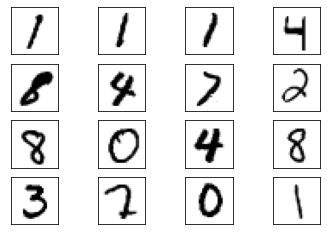

In [7]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

Preparing the Discriminator

In [8]:
class Discriminator(nn.Module):

    def __init__(self):

        super().__init__()

        self.model = nn.Sequential(

            nn.Linear(784, 1024),

            nn.ReLU(),

            nn.Dropout(0.3),

            nn.Linear(1024, 512),

            nn.ReLU(),

            nn.Dropout(0.3),

            nn.Linear(512, 256),

            nn.ReLU(),

            nn.Dropout(0.3),

            nn.Linear(256, 1),

            nn.Sigmoid(),

        )


    def forward(self, x):

        x = x.view(x.size(0), 784)

        output = self.model(x)

        return output

Instantiate the discriminator on the device

In [9]:
discriminator = Discriminator().to(device=device)

Preparing the Generator

In [10]:
class Generator(nn.Module):

    def __init__(self):

        super().__init__()

        self.model = nn.Sequential(

            nn.Linear(100, 256),

            nn.ReLU(),

            nn.Linear(256, 512),

            nn.ReLU(),

            nn.Linear(512, 1024),

            nn.ReLU(),

            nn.Linear(1024, 784),

            nn.Tanh(),

        )


    def forward(self, x):

        output = self.model(x)

        output = output.view(x.size(0), 1, 28, 28)

        return output

Instantiate the generator on the device

In [11]:
generator = Generator().to(device=device)

Setting up training parameters

In [12]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

Preparing optimezers

In [13]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Train the models

In [14]:
for epoch in range(num_epochs):

    for n, (real_samples, mnist_labels) in enumerate(train_loader):

        # Data for training the discriminator

        real_samples = real_samples.to(device=device)

        real_samples_labels = torch.ones((batch_size, 1)).to(

            device=device

        )

        latent_space_samples = torch.randn((batch_size, 100)).to(

            device=device

        )

        generated_samples = generator(latent_space_samples)

        generated_samples_labels = torch.zeros((batch_size, 1)).to(

            device=device

        )

        all_samples = torch.cat((real_samples, generated_samples))

        all_samples_labels = torch.cat(

            (real_samples_labels, generated_samples_labels)

        )


        # Training the discriminator

        discriminator.zero_grad()

        output_discriminator = discriminator(all_samples)

        loss_discriminator = loss_function(

            output_discriminator, all_samples_labels

        )

        loss_discriminator.backward()

        optimizer_discriminator.step()


        # Data for training the generator

        latent_space_samples = torch.randn((batch_size, 100)).to(

            device=device

        )


        # Training the generator

        generator.zero_grad()

        generated_samples = generator(latent_space_samples)

        output_discriminator_generated = discriminator(generated_samples)

        loss_generator = loss_function(

            output_discriminator_generated, real_samples_labels

        )

        loss_generator.backward()

        optimizer_generator.step()


        # Show loss

        if n == batch_size - 1:

            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")

            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5875952839851379
Epoch: 0 Loss G.: 0.4848797917366028
Epoch: 1 Loss D.: 0.05806529521942139
Epoch: 1 Loss G.: 5.153071403503418
Epoch: 2 Loss D.: 0.07664407789707184
Epoch: 2 Loss G.: 8.07432746887207
Epoch: 3 Loss D.: 0.02984347753226757
Epoch: 3 Loss G.: 7.504004001617432
Epoch: 4 Loss D.: 0.11426059901714325
Epoch: 4 Loss G.: 4.298037528991699
Epoch: 5 Loss D.: 0.09502187371253967
Epoch: 5 Loss G.: 2.663529872894287
Epoch: 6 Loss D.: 0.14287590980529785
Epoch: 6 Loss G.: 3.5501694679260254
Epoch: 7 Loss D.: 0.07712271064519882
Epoch: 7 Loss G.: 3.84006929397583
Epoch: 8 Loss D.: 0.21313214302062988
Epoch: 8 Loss G.: 3.823936700820923
Epoch: 9 Loss D.: 0.1273103654384613
Epoch: 9 Loss G.: 3.284196138381958
Epoch: 10 Loss D.: 0.17555154860019684
Epoch: 10 Loss G.: 4.129209518432617
Epoch: 11 Loss D.: 0.2917776107788086
Epoch: 11 Loss G.: 1.8039863109588623
Epoch: 12 Loss D.: 0.2728653848171234
Epoch: 12 Loss G.: 1.643632411956787
Epoch: 13 Loss D.: 0.37560054659843

Checking the Samples Generated by the GAN

In [15]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

Plotting the Samples

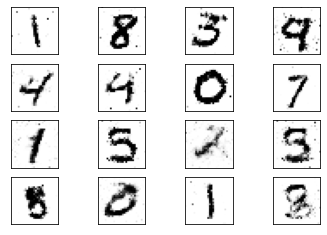

In [16]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])